<a href="https://colab.research.google.com/github/asokraju/ml-grinding/blob/master/hands_on_ml/Ch_3_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pprint as pp

import os
import urllib
import tarfile
import urllib.request
from zipfile import ZipFile

import scipy
from scipy import stats

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
#from sklearn.externals import joblib

from sklearn.multiclass import OneVsOneClassifier

from sklearn.neighbors import KNeighborsClassifier

from pandas.plotting import scatter_matrix

np.random.seed(42)
random.seed(42)

#EX-1

##data

In [ ]:
#mnist = fetch_openml('mnist_784', data_home='mnist_dataset/')
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
#X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
print("test : ",len(X_test),"\ntrain : ",len(X_train))

test :  10000 
train :  60000


In [ ]:
pipeline = Pipeline([
                     ('std_scaler', StandardScaler()),
                     ('knn_clf', KNeighborsClassifier())
                     
])
pp.pprint(sorted(pipeline.get_params().keys()))

['knn_clf',
 'knn_clf__algorithm',
 'knn_clf__leaf_size',
 'knn_clf__metric',
 'knn_clf__metric_params',
 'knn_clf__n_jobs',
 'knn_clf__n_neighbors',
 'knn_clf__p',
 'knn_clf__weights',
 'memory',
 'std_scaler',
 'std_scaler__copy',
 'std_scaler__with_mean',
 'std_scaler__with_std',
 'steps',
 'verbose']


In [ ]:
param_grid = [
              {#'knn_clf__weights':['uniform', 'distance'],
               'knn_clf__n_neighbors':[2,5,8],#,5
              'knn_clf__p':[1,2]#1
               }
]
#best params{'knn_clf__n_neighbors': 5, 'knn_clf__p': 1}


In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std_scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn_clf',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
   

In [ ]:
cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["accuracy"], cvres['params']):
#     print(np.sqrt(-mean_score), params)
grid_search.best_params_

{'knn_clf__n_neighbors': 5, 'knn_clf__p': 1}

In [ ]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn_clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=1,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
final_model = grid_search.best_estimator_
final_predictions = grid_search.best_estimator_.predict(X_test)

[[ 980    2    0    0    0    0    3    0    0    1]
 [   0 1123    0    0    1    0    1    0    0    0]
 [  11   21  939    7    2    0    2   16    1    0]
 [   0    5    7  982    0   11    2    6    5    2]
 [   0    9    1    0  935    0    2    3    0   25]
 [   6    3    0   13    2  857   11    2    2    6]
 [   6    2    0    0    1    6  966    0    1    0]
 [   2   16    3    0    8    0    0  997    0   16]
 [   8   16    1   26    8   22    4    3  875   12]
 [   2   11    0    9   12    2    0   16    2  940]]


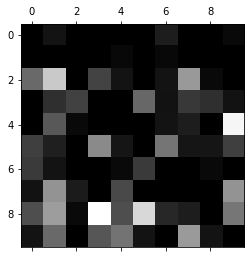

In [ ]:
conf_mat = confusion_matrix(y_test, final_predictions)
print(conf_mat)
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

#EX-2

In [ ]:
def data_augmentation(X_train, y_train):
    shifted_images = []
    shifted_img_labels = []
    for img, lab in zip(X_train, y_train):
        for r_shift in [-1,1]:
            for rc_shift in [-1,1]:
                shifted_image = scipy.ndimage.shift(input = img, shift = [r_shift, rc_shift])
                shifted_images.append(shifted_image)
                shifted_img_labels.append(lab)
    return np.array(shifted_images), np.array(shifted_img_labels)
